In [ ]:
!wget wget https://data.deepai.org/set5.zip
# !unzip -q set5.zip
# !unzip -q set5/SR_testing_datasets.zip
# !unzip -q set5/SR_training_datasets.zip

--2022-01-22 11:36:01--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2022-01-22 11:36:02--  https://data.deepai.org/set5.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407631796 (389M) [application/x-zip-compressed]
Saving to: ‘set5.zip’

set5.zip            100%[===================>] 388.75M   111MB/s    in 3.9s    

2022-01-22 11:36:06 (99.8 MB/s) - ‘set5.zip’ saved [407631796/407631796]

FINISHED --2022-01-22 11:36:06--
Total wall clock time: 4.2s
Downloaded: 1 files, 389M in 3.9s (99.8 MB/s)


In [ ]:
!pip install tensorflow-datasets==3.0.0
!pip install tensorflow-io

     |████████████████████████████████| 3.3 MB 5.1 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1
     |████████████████████████████████| 23.1 MB 1.3 MB/s 


In [ ]:
import cv2,os,sys
import matplotlib.pyplot as plt

d_path = '/content/Set5'
imgs = os.listdir(d_path)
fig = plt.figure(figsize=(10,20))
rows = len(imgs)
cols = 2
idx = 1
for x in (imgs):
    img = cv2.imread(os.path.join(d_path,x))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(rows,cols,idx)
    ax.imshow(img)

    ax = fig.add_subplot(rows,cols,idx+1)
    img_s = cv2.resize(img,dsize=(0, 0), fx=0.25, fy=0.25,
                       interpolation=cv2.INTER_LINEAR)
    ax.imshow(img_s)
    idx +=2
plt.show()
# print(img.shape)
# plt.imshow(img)

FileNotFoundError: ignored

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
# 데이터 불러오기
train, valid = tfds.load(
    "div2k",
    split=['train', 'validation'],
    as_supervised=True
)

batch_size = 8
def preprocessing(lr, hr):
    hr = (tf.cast(hr, tf.float32)-127.5 )/ 127.5

    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])

    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(batch_size)
valid = valid.map(preprocessing).repeat().batch(batch_size)

In [ ]:
from tensorflow.keras import Input, Model, layers

def residual_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x,out])

def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x,2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)

def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape) # 24,24,3

    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)

    for _ in range(5):
        out = residual_block(out)

    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])

    for _ in range(2):
        out = upsample_block(out)
    
    out = layers.Conv2D(3, 9, 1, "same", activation='tanh')(out)
    return Model(inputs, out)

In [ ]:
def disc_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)

    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)

    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)

    for n_filters in [128, 256, 512]:
        out = disc_block(out, n_filters)
    out = layers.GlobalAveragePooling2D()(out)
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

disc = get_discriminator()

In [ ]:
from tensorflow.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top = False,
        weights = "imagenet",
        input_shape=input_shape
    )
    return Model(vgg.input, vgg.layers[20].output)

fe = get_feature_extractor()

In [ ]:
fe
from tensorflow.keras.utils import plot_model
plot_model(fe, to_file='model_shapes.png', show_shapes=True)

(1, 24, 24, 3) (1, 96, 96, 3)
0.99454665 -0.012285542


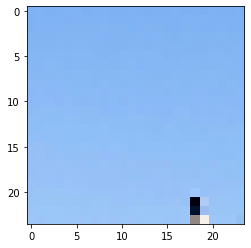

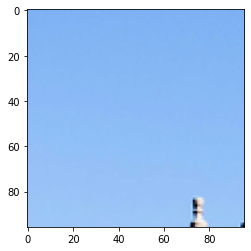

In [ ]:
for x,y in train.take(1):
    print(x.shape,y.shape)
    print(np.max(x),np.min(x))
    plt.imshow(x[0])
    plt.show()
    plt.imshow(y[0])
    plt.show()


# test = test[np.newaxis,:,:,:]

In [ ]:
print(np.max(applications.vgg19.preprocess_input(test)))
print(np.min(applications.vgg19.preprocess_input(test)))

-102.95239
-124.08163


In [ ]:
from tensorflow.keras import losses, metrics, optimizers
from collections import defaultdict
from IPython import display
generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def adversarial_gen_loss(fake_out,alpha=1e-3): # l_gen^SR
    # G(image) = fake_out
    # return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)
    return -alpha * bce(tf.ones_like(fake_out),fake_out)

    
@tf.function
def vgg_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)

    hr_real_feature = vgg(hr_real)
    hr_fake_feature = vgg(hr_fake)
    return mse(hr_real_feature, hr_fake_feature)

@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)

        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)

        perceptual_loss = (vgg_loss(hr_real,hr_fake)/(96*96) + adversarial_gen_loss(fake_out,alpha=1) + mse(hr_fake, hr_real)/(96*96))/batch_size
        discriminator_loss = (bce(real_out,tf.ones_like(real_out))/batch_size) - (bce(fake_out,tf.ones_like(fake_out))/batch_size)

    gen_gradient = gene_tape.gradient(perceptual_loss,generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss,discriminator.trainable_variables)

    # print(type(perceptual_loss),type(generator.trainable_variables))
    gene_opt.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss

gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

hist = defaultdict(list)
for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss 출력하기
        if (i+1) % 10 == 0:
            hist['g_loss'].append(g_loss)
            hist['d_loss'].append(d_loss)
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
            
        if (i+1) == 200:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
            x = lr
            y = hr
            fig = plt.figure(figsize=(30,10))
            rows = 3
            cols = 1
            # for x,y in train.take(1):
            for img in range(len(x)):
                test = x[img][np.newaxis,:,:,:]
                sr_img = generator(test)
                pro = discriminator(sr_img)
                ax = fig.add_subplot(rows,cols,  1)
                ax.imshow((x[img]+1)/2)
                ax.set_title('Prob :{:.4f}'.format(float(pro)))

                ax = fig.add_subplot(rows,cols, 2)
                ax.imshow((y[img]+1)/2)

                
                ax = fig.add_subplot(rows,cols, 3)
                ax.imshow((sr_img.numpy().reshape(y[0].shape)+1)/2)
                plt.show()
                
                # display.clear_output(wait=True)
            break
    
    gene_losses.reset_states()
    disc_losses.reset_states()

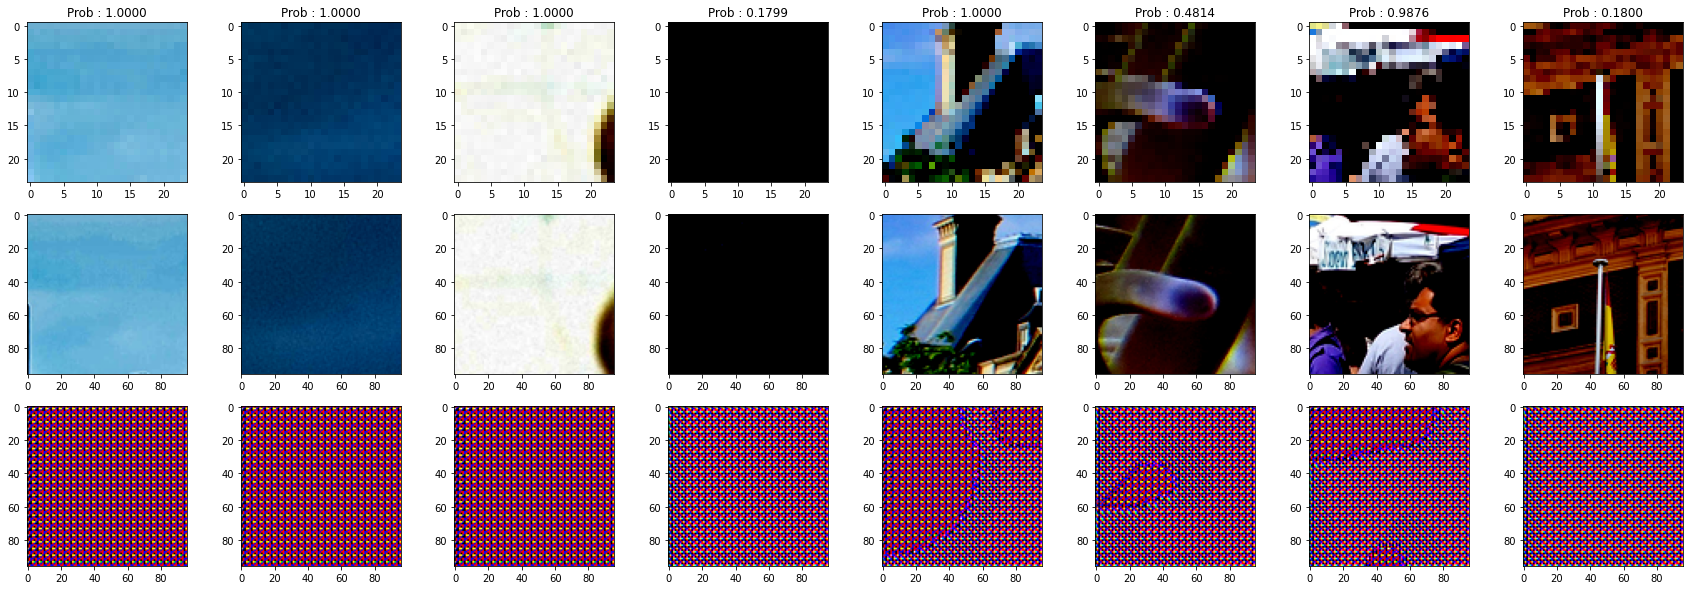

In [39]:
import warnings
warnings.filterwarnings(action='ignore')

fig = plt.figure(figsize=(30,10))
rows = 3
cols = 8
for x,y in train.take(1):
    for img in range(len(x)):
        test = x[img][np.newaxis,:,:,:]
        sr_img = generator(test)
        pro = discriminator(sr_img)
        ax = fig.add_subplot(rows,cols, img + 1)
        ax.imshow(x[img])
        ax.set_title('Prob : {:.4f}'.format(float(pro)))
        ax = fig.add_subplot(rows,cols, img + 9)
        ax.imshow(y[img])

        
        ax = fig.add_subplot(rows,cols, img + 17)
        ax.imshow((sr_img.numpy().reshape(y[0].shape)+1)/2)
    # print('True per :{:.4f}'.format(float(discriminator(test).numpy().reshape(1))))
    # test = x[0][np.newaxis,:,:,:]
    # sr_img = generator(test)
    # plt.imshow(sr_img.numpy().reshape(y[0].shape))
    # print(generator(test).shape)
    

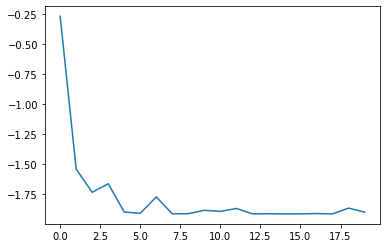

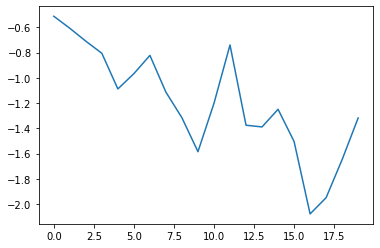

In [40]:
d_loss = [float(x) for x in hist['d_loss']]
g_loss = [float(x) for x in hist['g_loss']]


plt.plot(range(len(d_loss)),d_loss)
plt.show()
plt.plot(range(len(g_loss)),g_loss)
plt.show()

(1, 24, 24, 3) (1, 96, 96, 3)
0.9866115 -0.9909007


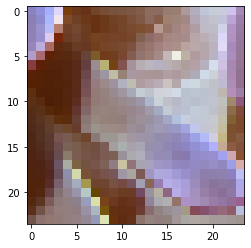

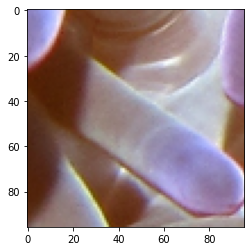

True per :0.5002


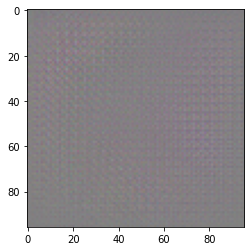

In [ ]:

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()
for x,y in train.take(1):
    print(x.shape,y.shape)
    print(np.max(x),np.min(x))
    plt.imshow((x[0]+1)/2)
    plt.show()
    plt.imshow((y[0]+1)/2)
    plt.show()
    test = x[0][np.newaxis,:,:,:]
    sr_img = generator(test)
    plt.imshow((sr_img.numpy().reshape(y[0].shape)+1)/2)
    # print(generator(test).shape)
    print('True per :{:.4f}'.format(float(discriminator(test).numpy().reshape(1))))